## Assignment 2
## Author: Haonan Tian 

In [125]:
import csv
import time
import os
import io
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

### Load Data

In [126]:
current_path = os.getcwd()
def read_data(path, filename):
    with open(current_path+'/hw2_data/' + filename) as tsv:
        reader = csv.reader(tsv, delimiter='\t')
        data_pre = []
        data_post = []
        label = []
        for row in reader:
            data_pre.append(row[0])
            data_post.append(row[1])
            label.append(row[2])
        return data_pre[1:], data_post[1:], label[1:] 

In [215]:
def read_data_mnli(path, filename):
    with open(current_path+'/hw2_data/' + filename) as tsv:
        reader = csv.reader(tsv, delimiter='\t')
        counter = 0
        genre = []
        result = {}
        for row in reader:
            temp_list = []
            if counter > 0:
                genre = row[3]
                if genre in result:
                    temp_list.append(row[0])
                    temp_list.append(row[1])
                    temp_list.append(row[2])
                    result[genre].append(temp_list)
                else:
                    result[genre] = []
                    temp_list.append(row[0])
                    temp_list.append(row[1])
                    temp_list.append(row[2])
                    result[genre].append(temp_list)
            else:
                counter += 1
        return result

In [358]:
snli_train_pre, snli_train_post, snli_train_label = read_data(current_path, 'snli_train.tsv') 
snli_val_pre, snli_val_post, snli_val_label = read_data(current_path, 'snli_val.tsv') 
mnli_train = read_data_mnli(current_path, 'mnli_train.tsv') 
mnli_val= read_data_mnli(current_path, 'mnli_val.tsv') 

In [128]:
# Load embedding layers
def load_vectors(fname, vocab_size):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    counter = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        temp_list = []
        for item in tokens[1:]:
            temp_list.append(float(item))
        data[tokens[0]] = temp_list
        if counter % 1000 == 0:
            print('Finished line {}'.format(counter))
        counter += 1
        if counter >= vocab_size:
            break;
    return d, data

In [129]:
embed_dim, embed_dist = load_vectors(current_path+'/hw2_data/wiki-news-300d-1M.vec', 50000)

Finished line 0
Finished line 1000
Finished line 2000
Finished line 3000
Finished line 4000
Finished line 5000
Finished line 6000
Finished line 7000
Finished line 8000
Finished line 9000
Finished line 10000
Finished line 11000
Finished line 12000
Finished line 13000
Finished line 14000
Finished line 15000
Finished line 16000
Finished line 17000
Finished line 18000
Finished line 19000
Finished line 20000
Finished line 21000
Finished line 22000
Finished line 23000
Finished line 24000
Finished line 25000
Finished line 26000
Finished line 27000
Finished line 28000
Finished line 29000
Finished line 30000
Finished line 31000
Finished line 32000
Finished line 33000
Finished line 34000
Finished line 35000
Finished line 36000
Finished line 37000
Finished line 38000
Finished line 39000
Finished line 40000
Finished line 41000
Finished line 42000
Finished line 43000
Finished line 44000
Finished line 45000
Finished line 46000
Finished line 47000
Finished line 48000
Finished line 49000


In [359]:
# Create label set
def convert_label(label_list):
    result = []
    for item in label_list:
        if item == 'contradiction':
            result.append(0)
        elif item == 'entailment':
            result.append(1)
        elif item == 'neutral':
            result.append(2)
    return result

In [360]:
snli_train_label = convert_label(snli_train_label)
snli_val_label = convert_label(snli_val_label)

### Tokenization

In [132]:
def convert_to_token(input_set):
    result = []
    counter = 0
    for row in input_set:
        result.append(row.split(' '))
        if counter % 5000 == 0:
            print('FINISHED {}'.format(counter))
        counter += 1
    return result

In [361]:
snli_train_pre = convert_to_token(snli_train_pre)
snli_train_post = convert_to_token(snli_train_post)

snli_val_pre = convert_to_token(snli_val_pre) 
snli_val_post = convert_to_token(snli_val_post)

FINISHED 0
FINISHED 5000
FINISHED 10000
FINISHED 15000
FINISHED 20000
FINISHED 25000
FINISHED 30000
FINISHED 35000
FINISHED 40000
FINISHED 45000
FINISHED 50000
FINISHED 55000
FINISHED 60000
FINISHED 65000
FINISHED 70000
FINISHED 75000
FINISHED 80000
FINISHED 85000
FINISHED 90000
FINISHED 95000
FINISHED 0
FINISHED 5000
FINISHED 10000
FINISHED 15000
FINISHED 20000
FINISHED 25000
FINISHED 30000
FINISHED 35000
FINISHED 40000
FINISHED 45000
FINISHED 50000
FINISHED 55000
FINISHED 60000
FINISHED 65000
FINISHED 70000
FINISHED 75000
FINISHED 80000
FINISHED 85000
FINISHED 90000
FINISHED 95000
FINISHED 0
FINISHED 0


### Build Vocabulary

In [161]:
def find_all_tokens(input_set):
    all_sentence = []
    for sentence in input_set:
        all_sentence += sentence
    output = Counter(all_sentence)
    result = []
    for key, value in output.items():
        result.append(key)
    return result

In [362]:
all_tokens = find_all_tokens(snli_train_pre+snli_train_post)

In [157]:
def build_lookup(all_tokens, embed_dist):
    result = {}
    counter = 1
    for item in all_tokens:
        if item in embed_dist:
            result[item] = counter
        else:
            result[item] = 0
        counter += 1
    return result

In [363]:
lookup = build_lookup(all_tokens, embed_dist)

In [169]:
def rebuild_embed_dict(embed_dict, lookup, embed_dim):
    result = {}
    result[0] = [0 for i in range(embed_dim)]
    for key, value in lookup.items():
        if key in embed_dict:
            result[value] = embed_dict[key]
    return result

In [364]:
idx_embed_dict = rebuild_embed_dict(embed_dist, lookup, embed_dim)

In [171]:
def convert_to_idx(input_set, lookup):
    result = []
    for sentence in input_set:
        temp_result = []
        for token in sentence:
            if token in lookup:
                temp_result.append(lookup[token])
        result.append(temp_result)
    return result

In [365]:
snli_train_pre = convert_to_idx(snli_train_pre, lookup)
snli_train_post = convert_to_idx(snli_train_post, lookup)

snli_val_pre = convert_to_idx(snli_val_pre, lookup)
snli_val_post = convert_to_idx(snli_val_post, lookup)

In [173]:
def find_max_length(list1, list2):
    length1 = []
    length2 = []
    for item in list1:
        if len(item) != 0:
            length1.append(len(item))
        else:
            length1.append(1)
    for item in list2:
        if len(item) != 0:
            length2.append(len(item))
        else:
            length2.append(1)
    return max([max(length1), max(length2)]), length1, length2

In [366]:
MAX_WORD_LENGTH, snli_train_pre_len, snli_train_post_len = find_max_length(snli_train_pre, snli_train_post)
_, snli_val_pre_len, snli_val_post_len = find_max_length(snli_val_pre, snli_val_post)

In [177]:
def secure_idx(input_set, max_length):
    for sentence in input_set:
        if len(sentence) == 0:
            for i in range(max_length):
                sentence.append(0)

In [367]:
secure_idx(snli_train_pre, MAX_WORD_LENGTH)
secure_idx(snli_train_post, MAX_WORD_LENGTH)
secure_idx(snli_val_pre, MAX_WORD_LENGTH)
secure_idx(snli_val_post, MAX_WORD_LENGTH)

In [369]:
def setup_each_genre(data_set, embed_dist, embed_dim):
    result = {}
    for genre, value in data_set.items():
        temp_list = []
        pre = []
        post = []
        label = []
        for sample in value:
            pre.append(sample[0])
            post.append(sample[1])
            label.append(sample[2])
        pre = convert_to_token(pre)
        post = convert_to_token(post)
        all_tokens = find_all_tokens(pre+post)
        lookup = build_lookup(all_tokens, embed_dist)
        idx_embed_dict = rebuild_embed_dict(embed_dist, lookup, embed_dim)
        pre = convert_to_idx(pre, lookup)
        post = convert_to_idx(post, lookup)
        max_length, pre_lengths, post_lengths = find_max_length(pre, post)
        secure_idx(pre, max_length)
        secure_idx(post, max_length)
        temp_list.append(pre)
        temp_list.append(post)
        temp_list.append(pre_lengths)
        temp_list.append(post_lengths)
        temp_list.append(convert_label(label))
        result[genre] = temp_list
    return result, idx_embed_dict

In [370]:
mnli_train, _ = setup_each_genre(mnli_train, embed_dist, embed_dim)
mnli_val, idx_embed_dict_mn = setup_each_genre(mnli_val, embed_dist, embed_dim)

FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0
FINISHED 0


### GRU

In [197]:
device = torch.device('cpu')
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [189]:
class localDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_pre, data_post, pre_length, post_length, data_label):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_pre, self.data_post, self.data_label = data_pre, data_post, data_label
        self.pre_length = pre_length
        self.post_length = post_length
        assert (len(self.data_pre) == len(self.data_post)) and (len(self.data_pre) == len(self.data_label))

    def __len__(self):
        return len(self.data_pre)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        idx_pre = self.data_pre[key]
        idx_post = self.data_post[key]
        pre_length = self.pre_length[key]
        post_length = self.post_length[key]
        idx_label = self.data_label[key]
        return [idx_pre, idx_post, pre_length, post_length, idx_label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_pre = []
    data_post = []
    label_list = []
    length_pre = []
    length_post = []

    for datum in batch:
        label_list.append(datum[4])
        length_pre.append(datum[2])
        length_post.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_pre = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        data_pre.append(padded_vec_pre)
        padded_vec_post = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_post.append(padded_vec_post)
    
    pre_dec_order = np.argsort(length_pre)[::-1] # Sort all list accoridng to length in decreasing order
    post_dec_order = np.argsort(length_post)[::-1]
    data_pre = np.array(data_pre)[pre_dec_order]
    data_post = np.array(data_post)[pre_dec_order]
    length_pre = np.array(length_pre)[pre_dec_order]
    length_post = np.array(length_post)[post_dec_order]
    label_list = np.array(label_list)[pre_dec_order]
    data_pre = torch.from_numpy(np.array(data_pre))
    data_pre = data_pre.type('torch.FloatTensor')
    data_post = torch.from_numpy(np.array(data_post))
    data_post = data_post.type('torch.FloatTensor')
    return [data_pre, data_post, torch.LongTensor(length_pre), torch.LongTensor(length_post), torch.LongTensor(label_list)]

In [190]:
# Build train, valid and test dataloaders
BATCH_SIZE =128

snli_train_dataset = localDataset(snli_train_pre, snli_train_post, snli_train_pre_len, snli_train_post_len, snli_train_label)
snli_train_loader = torch.utils.data.DataLoader(dataset=snli_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

snli_val_dataset = localDataset(snli_val_pre, snli_val_post, snli_val_pre_len, snli_val_post_len, snli_val_label)
snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [191]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # Details can be seen at https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html 
        self.linear = nn.Linear(4*hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)

        return hidden.to(device)
    
    def perform_embed(self, data_set, idx_embed_dict):
        result = []
        for sentence in data_set.numpy().tolist():
            temp_result = []
            for idx in sentence:
                temp_result.append(idx_embed_dict[idx])
            result.append(temp_result)
        return torch.from_numpy(np.array(result)).type('torch.FloatTensor').to(device)

    def forward(self, data_pre, data_post, pre_lengths, post_lengths, idx_embed_dict):
        # reset hidden state

        batch_size,_ = data_pre.size()

        self.hidden_pre = self.init_hidden(batch_size)
        self.hidden_post = self.init_hidden(batch_size)        

        # get embedding of characters
        embed_pre = self.perform_embed(data_pre.cpu(), idx_embed_dict)#.type('torch.FloatTensor')
        embed_post = self.perform_embed(data_post.cpu(), idx_embed_dict)#.type('torch.FloatTensor')
        
        # pack padded sequence
        embed_pre = torch.nn.utils.rnn.pack_padded_sequence(embed_pre, pre_lengths.numpy(), batch_first=True)
        embed_post = torch.nn.utils.rnn.pack_padded_sequence(embed_post, post_lengths.numpy(), batch_first=True)
        # According to Pytorch, the pack_padded_sequance take input with dimension batch_size if batch_first == True
        # and maximum sequence length and embedding dimensions refer to https://pytorch.org/docs/stable/nn.html 
        
        # fprop though RNN
        rnn_out_pre, self.hidden_pre = self.rnn(embed_pre, self.hidden_pre)
        rnn_out_post, self.hidden_post = self.rnn(embed_post, self.hidden_post)
        
        # undo packing
        rnn_out_pre, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_pre, batch_first=True)
        rnn_out_post, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out_post, batch_first=True)
        
        # sum hidden activations of RNN across time
        rnn_out_pre = torch.sum(rnn_out_pre, dim=1)
        rnn_out_post = torch.sum(rnn_out_post, dim=1)
        rnn_out = torch.cat((rnn_out_pre, rnn_out_post), 1)

        logits = self.linear(rnn_out)
        return logits

In [192]:
def test_model(loader, model, idx_embed_dict):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_pre, data_post, lengths_pre, lengths_post, labels in loader:
        data_batch_pre, lengths_batch_pre, data_batch_post, lengths_batch_post, label_batch = data_pre.to(device), lengths_pre, data_post.to(device), lengths_post, labels
        outputs = F.softmax(model(data_batch_pre, data_batch_post, lengths_batch_pre, lengths_batch_post, idx_embed_dict), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
    return (100 * correct / total)


model = GRU(emb_size=embed_dim, hidden_size=200, num_layers=2, num_classes=3).cuda()

learning_rate = 3e-4
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(snli_val_loader)
#print(len(snli_train_loader))

for epoch in range(num_epochs):
    for i, (data_pre, data_post, pre_lengths, post_lengths, labels) in enumerate(snli_train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        labels.to(device)
        outputs = model(data_pre, data_post, pre_lengths, post_lengths, idx_embed_dict)
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(snli_val_loader, model, idx_embed_dict)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(snli_train_loader), val_acc))
final_accuracy = test_model(snli_val_loader, model, idx_embed_dict)
print('Final Test Acc: {}'.format(final_accuracy))

Epoch: [1/10], Step: [101/782], Validation Acc: 36.2
Epoch: [1/10], Step: [201/782], Validation Acc: 39.1
Epoch: [1/10], Step: [301/782], Validation Acc: 43.1
Epoch: [1/10], Step: [401/782], Validation Acc: 45.8
Epoch: [1/10], Step: [501/782], Validation Acc: 48.0
Epoch: [1/10], Step: [601/782], Validation Acc: 46.2
Epoch: [1/10], Step: [701/782], Validation Acc: 47.4
Epoch: [2/10], Step: [101/782], Validation Acc: 51.4
Epoch: [2/10], Step: [201/782], Validation Acc: 52.1
Epoch: [2/10], Step: [301/782], Validation Acc: 50.6
Epoch: [2/10], Step: [401/782], Validation Acc: 50.8
Epoch: [2/10], Step: [501/782], Validation Acc: 51.8
Epoch: [2/10], Step: [601/782], Validation Acc: 52.8
Epoch: [2/10], Step: [701/782], Validation Acc: 53.4
Epoch: [3/10], Step: [101/782], Validation Acc: 54.3
Epoch: [3/10], Step: [201/782], Validation Acc: 53.3
Epoch: [3/10], Step: [301/782], Validation Acc: 52.6
Epoch: [3/10], Step: [401/782], Validation Acc: 53.3
Epoch: [3/10], Step: [501/782], Validation Acc

### CNN

In [297]:
CNN_list = {}

In [298]:
class localDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_pre, data_post, pre_length, post_length, data_label):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_pre, self.data_post, self.data_label = data_pre, data_post, data_label
        self.pre_length = pre_length
        self.post_length = post_length
        assert (len(self.data_pre) == len(self.data_post)) and (len(self.data_pre) == len(self.data_label))

    def __len__(self):
        return len(self.data_pre)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        idx_pre = self.data_pre[key]
        idx_post = self.data_post[key]
        pre_length = self.pre_length[key]
        post_length = self.post_length[key]
        idx_label = self.data_label[key]
        return [idx_pre, idx_post, pre_length, post_length, idx_label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_pre = []
    data_post = []
    label_list = []
    length_pre = []
    length_post = []

    for datum in batch:
        label_list.append(datum[4])
        length_pre.append(datum[2])
        length_post.append(datum[3])
    # padding
    for datum in batch:
        padded_vec_pre = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[2])),
                                mode="constant", constant_values=0)
        data_pre.append(padded_vec_pre)
        padded_vec_post = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[3])),
                                mode="constant", constant_values=0)
        data_post.append(padded_vec_post)
    
    pre_dec_order = np.argsort(length_pre)[::-1] # Sort all list accoridng to length in decreasing order
    post_dec_order = np.argsort(length_post)[::-1]
    data_pre = np.array(data_pre)[pre_dec_order]
    data_post = np.array(data_post)[pre_dec_order]
    length_pre = np.array(length_pre)[pre_dec_order]
    length_post = np.array(length_post)[post_dec_order]
    label_list = np.array(label_list)[pre_dec_order]
    data_pre = torch.from_numpy(np.array(data_pre)).type('torch.DoubleTensor')
    data_post = torch.from_numpy(np.array(data_post)).type('torch.DoubleTensor')
    return [data_pre, data_post, torch.LongTensor(length_pre), torch.LongTensor(length_post), torch.LongTensor(label_list)]

In [299]:
# Build train, valid and test dataloaders
BATCH_SIZE = 128

snli_train_dataset = localDataset(snli_train_pre, snli_train_post, snli_train_pre_len, snli_train_post_len, snli_train_label)
snli_train_loader = torch.utils.data.DataLoader(dataset=snli_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

snli_val_dataset = localDataset(snli_val_pre, snli_val_post, snli_val_pre_len, snli_val_post_len, snli_val_label)
snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [300]:
import math
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, max_length):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool1d(max_length, stride=1)

        self.linear = nn.Linear(2*hidden_size, hidden_size)
        
        self.linear2 = nn.Linear(hidden_size, num_classes)
    
    def perform_embed(self, data_set, idx_embed_dict):
        result = []
        for sentence in data_set.numpy().tolist():
            temp_result = []
            for idx in sentence:
                temp_result.append(idx_embed_dict[idx])
            result.append(temp_result)
        return torch.from_numpy(np.array(result)).type('torch.FloatTensor').to(device)

    def forward(self, data_pre, data_post, idx_embed_dict):
        batch_size, max_lengths = data_pre.size()

        data_pre = self.perform_embed(data_pre.cpu(), idx_embed_dict)#.type('torch.FloatTensor')
        data_post = self.perform_embed(data_post.cpu(), idx_embed_dict)#.type('torch.FloatTensor')
        #print('data_pre {}'.format(data_pre.is_cuda))
        
        hidden_pre = self.conv1(data_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, max_lengths, hidden_pre.size(-1))
        
        hidden_pre = self.conv2(hidden_pre.transpose(1,2)).transpose(1,2)
        hidden_pre = F.relu(hidden_pre.contiguous().view(-1, hidden_pre.size(-1))).view(batch_size, max_lengths, hidden_pre.size(-1))
        
        hidden_post = self.conv1(data_post.transpose(1,2)).transpose(1,2)
        hidden_post = F.relu(hidden_post.contiguous().view(-1, hidden_post.size(-1))).view(batch_size, max_lengths, hidden_post.size(-1))
        
        hidden_post = self.conv2(hidden_post.transpose(1,2)).transpose(1,2)
        hidden_post = F.relu(hidden_post.contiguous().view(-1, hidden_post.size(-1))).view(batch_size, max_lengths, hidden_post.size(-1))
        
        hidden_pre = hidden_pre.transpose(1,2)
        hidden_pre = self.maxpool(hidden_pre)
        hidden_pre = hidden_pre.transpose(1,2).squeeze(1)
        
        hidden_post = hidden_post.transpose(1,2)
        hidden_post = self.maxpool(hidden_post)
        hidden_post = hidden_post.transpose(1,2).squeeze(1)
        
        hidden = torch.cat((hidden_pre, hidden_post), 1)
        hidden = self.linear(hidden)
        hidden = torch.relu(hidden)
        logits = self.linear2(hidden)
        return logits

In [349]:
def test_model(loader, model, idx_embed_dict):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_pre, data_post, pre_lengths, post_lengths, labels in loader:
        data_batch_pre, data_batch_post, lengths_batch_pre, lengths_batch_post, label_batch = data_pre, data_post, pre_lengths, post_lengths, labels
        outputs = F.softmax(model(data_batch_pre, data_batch_post, idx_embed_dict), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
    return (100 * correct / total)

model = CNN(emb_size=300, hidden_size=1000, num_layers=2, num_classes=3, max_length=MAX_WORD_LENGTH).to(device)

learning_rate = 3e-4
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(snli_val_loader)
    
learning_loss = []
learning_accu = []
training_example = []
final_accuracy = 0
record = 0
for epoch in range(num_epochs):
    for i, (data_pre, data_post, pre_lengths, post_lengths, labels) in enumerate(snli_train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        record += len(list(data_pre))
        outputs = model(data_pre.to(device), data_post.to(device), idx_embed_dict)
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(snli_val_loader, model, idx_embed_dict)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                        epoch+1, num_epochs, i+1, len(snli_train_loader), val_acc))
            learning_loss.append(criterion(outputs, labels.to(device)))
            learning_accu.append(val_acc)
            training_example.append(record)
final_accuracy = test_model(snli_val_loader, model, idx_embed_dict)
print('Final Test Acc: {}'.format(final_accuracy))

hidden_size = 300 # Change this variable when testing different parameters
kernel_size = 3 # Change this variable when testing different parameters
CNN_list[final_accuracy] = [hidden_size, kernel_size]

Epoch: [1/5], Step: [101/782], Validation Acc: 56.0
Epoch: [1/5], Step: [201/782], Validation Acc: 61.5
Epoch: [1/5], Step: [301/782], Validation Acc: 61.6
Epoch: [1/5], Step: [401/782], Validation Acc: 63.5
Epoch: [1/5], Step: [501/782], Validation Acc: 62.7
Epoch: [1/5], Step: [601/782], Validation Acc: 62.7
Epoch: [1/5], Step: [701/782], Validation Acc: 64.7
Epoch: [2/5], Step: [101/782], Validation Acc: 65.1
Epoch: [2/5], Step: [201/782], Validation Acc: 66.1
Epoch: [2/5], Step: [301/782], Validation Acc: 66.7
Epoch: [2/5], Step: [401/782], Validation Acc: 65.4
Epoch: [2/5], Step: [501/782], Validation Acc: 68.0
Epoch: [2/5], Step: [601/782], Validation Acc: 67.2
Epoch: [2/5], Step: [701/782], Validation Acc: 67.8
Epoch: [3/5], Step: [101/782], Validation Acc: 66.0
Epoch: [3/5], Step: [201/782], Validation Acc: 67.3
Epoch: [3/5], Step: [301/782], Validation Acc: 67.2
Epoch: [3/5], Step: [401/782], Validation Acc: 69.6
Epoch: [3/5], Step: [501/782], Validation Acc: 68.4
Epoch: [3/5]

In [350]:
training_example

[12928,
 25728,
 38528,
 51328,
 64128,
 76928,
 89728,
 112928,
 125728,
 138528,
 151328,
 164128,
 176928,
 189728,
 212928,
 225728,
 238528,
 251328,
 264128,
 276928,
 289728,
 312928,
 325728,
 338528,
 351328,
 364128,
 376928,
 389728,
 412928,
 425728,
 438528,
 451328,
 464128,
 476928,
 489728]

In [307]:
# Find Three correctly labeled samples 
def list_three_correct(loader, model, idx_embed):
    model.eval()
    correct_sample = []
    correct_label = []
    counter_c = 0
    
    for data_pre, data_post, pre_lengths, post_lengths, labels in loader:
        data_batch_pre, data_batch_post, pre_length_batch, post_length_batch, label_batch = data_pre, data_post, pre_lengths, post_lengths, labels
        outputs = F.softmax(model(data_pre, data_post, idx_embed), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correction = list(predicted.eq(labels.view_as(predicted).to(device)))
        label = list(labels)
        data_content_pre = list(data_pre)
        data_content_post = list(data_post)
        inner_counter = 0
        while inner_counter < len(correction):
            if correction[inner_counter] == 1:
                temp_list = []
                temp_list.append(list(data_content_pre[inner_counter].numpy()))
                temp_list.append(list(data_content_post[inner_counter].numpy()))
                correct_sample.append(temp_list)
                correct_label.append(label[inner_counter].item())
                #(data_content[inner_counter])
                inner_counter += 1
                counter_c += 1
                if counter_c == 3:
                    break
            else:
                inner_counter += 1
        break
    
    return correct_sample, correct_label

In [308]:
correct_sample, correct_label = list_three_correct(snli_val_loader, model, idx_embed_dict)

In [322]:
result = []
for item in correct_sample:
    pre = item[0]
    post = item[1]
    pre_result = ''
    post_result = ''
    for inneritem in pre:
        for key, value in lookup.items():
            if value != 0  and value == inneritem:
                pre_result += key + ' '
                break
    for inneritem in post:
        for key, value in lookup.items():
            if value != 0  and value == inneritem:
                post_result += key + ' '
                break
    result.append([pre_result, post_result])

In [324]:
lab_correct = []
for item in correct_label:
    if item == 0:
        lab_correct.append('contradiction')
    elif item == 1:
        lab_correct.append('entailment')
    else:
        lab_correct.append('neutral')

In [331]:
fincorrect = open('three_correct_reviews.txt','w')
for i in range(3):
    fincorrect.write('The premice: ' + str(result[i][0]) + ' The hypothesis: ' + str(result[i][1]) + ' is correctly labeled as ' + str(lab_correct[i]) + '\n')
fincorrect.close()

In [338]:
# Find Three correctly labeled samples 
def list_three_incorrect(loader, model, idx_embed):
    model.eval()
    correct_sample = []
    correct_label = []
    counter_c = 0
    
    for data_pre, data_post, pre_lengths, post_lengths, labels in loader:
        data_batch_pre, data_batch_post, pre_length_batch, post_length_batch, label_batch = data_pre, data_post, pre_lengths, post_lengths, labels
        outputs = F.softmax(model(data_pre, data_post, idx_embed), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        correction = list(predicted.eq(labels.view_as(predicted).to(device)))
        label = list(labels)
        data_content_pre = list(data_pre)
        data_content_post = list(data_post)
        inner_counter = 0
        while inner_counter < len(correction):
            if correction[inner_counter] == 0:
                temp_list = []
                temp_list.append(list(data_content_pre[inner_counter].numpy()))
                temp_list.append(list(data_content_post[inner_counter].numpy()))
                correct_sample.append(temp_list)
                correct_label.append(label[inner_counter].item())
                #(data_content[inner_counter])
                inner_counter += 1
                counter_c += 1
                if counter_c == 3:
                    break
            else:
                inner_counter += 1
        break
    
    return correct_sample, correct_label

In [339]:
incorrect_sample, incorrect_label = list_three_incorrect(snli_val_loader, model, idx_embed_dict)

In [340]:
result = []
for item in incorrect_sample:
    pre = item[0]
    post = item[1]
    pre_result = ''
    post_result = ''
    for inneritem in pre:
        for key, value in lookup.items():
            if value != 0  and value == inneritem:
                pre_result += key + ' '
                break
    for inneritem in post:
        for key, value in lookup.items():
            if value != 0  and value == inneritem:
                post_result += key + ' '
                break
    result.append([pre_result, post_result])

In [341]:
lab_correct = []
for item in incorrect_label:
    if item == 0:
        lab_correct.append('contradiction')
    elif item == 1:
        lab_correct.append('entailment')
    else:
        lab_correct.append('neutral')

In [342]:
fincorrect = open('three_incorrect_reviews.txt','w')
for i in range(3):
    fincorrect.write('The premice: ' + str(result[i][0]) + ' The hypothesis: ' + str(result[i][1]) + ' is incorrectly labeled as ' + str(lab_correct[i]) + '\n')
fincorrect.close()

### Mnli_val

In [371]:
BATCH_SIZE = 128

def test_model(loader, model, idx_embed_dict):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data_pre, data_post, pre_lengths, post_lengths, labels in loader:
        data_batch_pre, data_batch_post, lengths_batch_pre, lengths_batch_post, label_batch = data_pre, data_post, pre_lengths, post_lengths, labels
        outputs = F.softmax(model(data_batch_pre, data_batch_post, idx_embed_dict), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.to(device).view_as(predicted)).sum().item()
    return (100 * correct / total)

result = {}
for genre, data_set in mnli_val.items():
    genre_current = genre
    temp_result = []
    MAX_WORD_LENGTH,_,_ = find_max_length(data_set[0], data_set[1])
    mnli_val_dataset = localDataset(data_set[0], data_set[1], data_set[2], data_set[3], data_set[4])
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
    model = CNN(emb_size=300, hidden_size=100, num_layers=2, num_classes=3, max_length=MAX_WORD_LENGTH)

    learning_rate = 3e-4
    num_epochs = 5 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(snli_val_loader)
    learning_loss = []
    learning_accu = []
    training_example = []
    final_accuracy = 0
    record = 0
    for epoch in range(num_epochs):
        for i, (data_pre, data_post, pre_lengths, post_lengths, labels) in enumerate(mnli_val_loader):
            record += len(list(data_pre))
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_pre.to(device), data_post.to(device), idx_embed_dict_mn)
            loss = criterion(outputs, labels.to(device))

            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 20 == 0:
                # validate
                val_acc = test_model(mnli_val_loader, model, idx_embed_dict)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(snli_train_loader), val_acc))
                learning_loss.append(criterion(outputs, labels))
                learning_accu.append(val_acc)
                training_example.append(record)
                final_accuracy = test_model(test_loader, model)
                print('Final Test Acc: {}'.format(final_accuracy))
    temp_result.append(final_accuracy)
    temp_result.append(training_example)
    temp_result.append(learning_accu)
    result[genre] = temp_result

KeyError: 1861.0

Text(0.5,1,'Learning Curve')

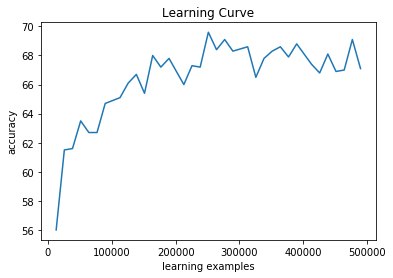

In [351]:
import matplotlib.pyplot as plt
import numpy as np
x = np.asarray(training_example)
y = np.asarray(learning_accu)
plt.plot(x, y)

#plt.xlim(5, 0)  # decreasing time

plt.xlabel('learning examples')
plt.ylabel('accuracy')
plt.title('Learning Curve')
#plt.grid(True)